In [ ]:
# 필요 라이브러리 임포트
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    classification_report,
    roc_auc_score,
    precision_recall_curve,
    auc
)
import lightgbm as lgb
from imblearn.over_sampling import SMOTE

# 시각화 스타일 설정
plt.style.use('seaborn-v0_8-darkgrid')
# Retina 디스플레이 지원
%config InlineBackend.figure_format = 'retina'

df = pd.read_csv('/content/creditcard.csv')

In [21]:
print("## 1. 데이터 분석 (Exploratory Data Analysis)\n")
print("데이터 첫 5행 확인:")
print(df.head())

## 1. 데이터 분석 (Exploratory Data Analysis)

데이터 첫 5행 확인:
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  

In [22]:
print("\n데이터 정보 확인:")
df.info()


데이터 정보 확인:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21

In [23]:
print("\n결측치 확인:")
print(df.isnull().sum().sum()) # 전체 결측치 개수 확인


결측치 확인:
0


/tmp/ipython-input-2949708161.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Class', data=df, palette=['#3498db', '#e74c3c'])


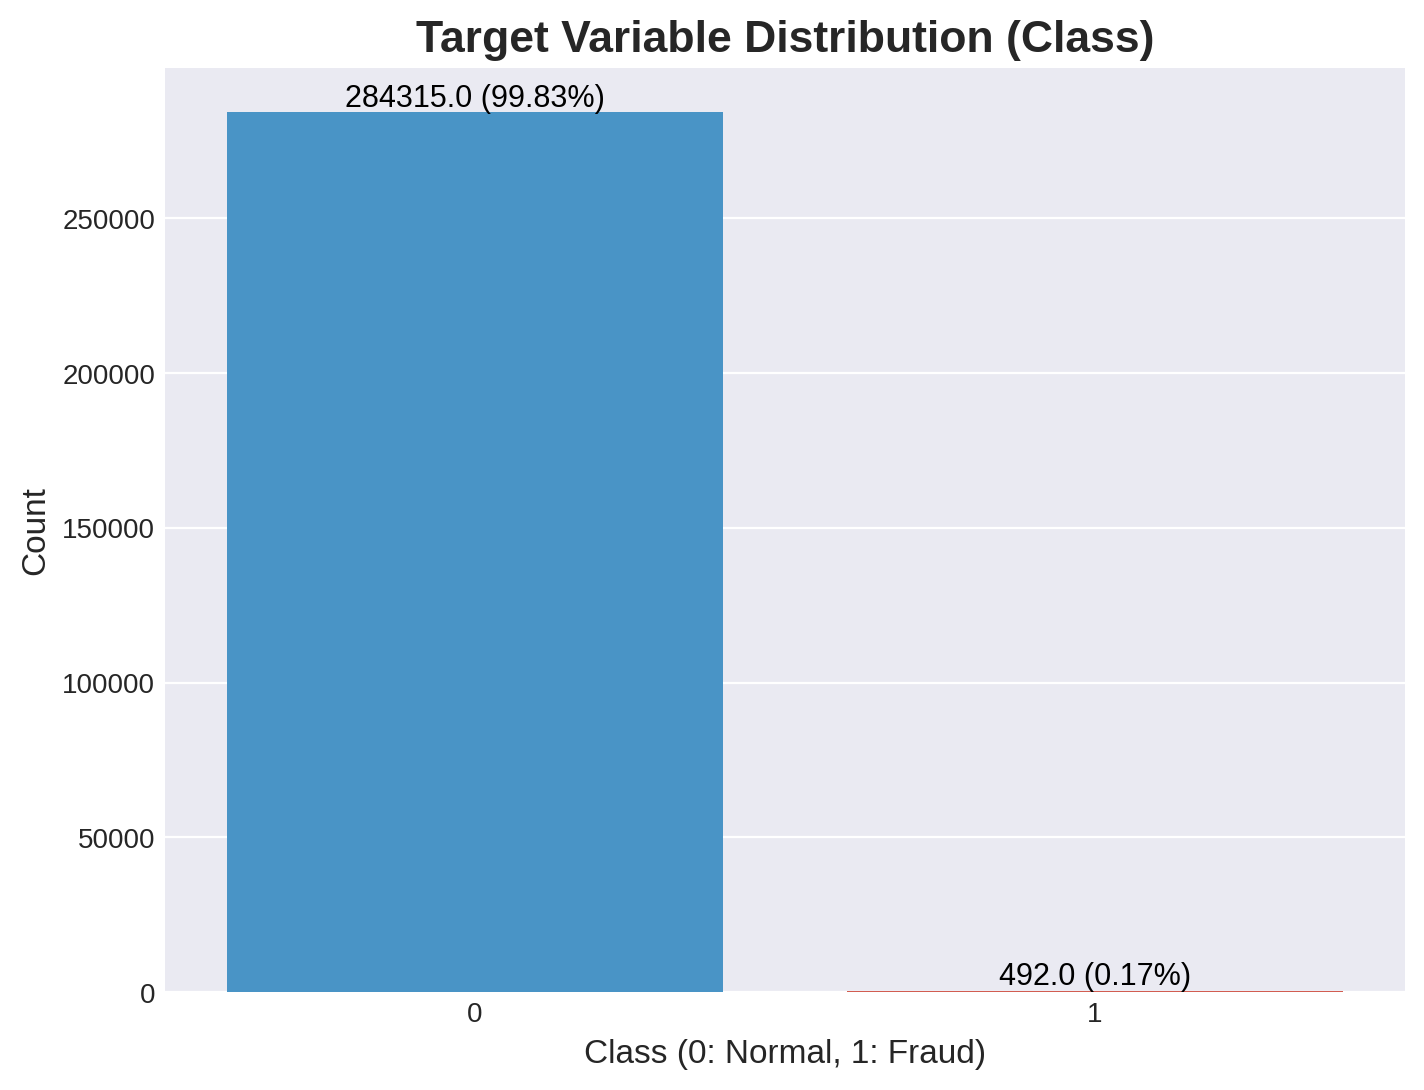

In [24]:
# --- 타겟 변수(Class) 분포 확인 ---
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Class', data=df, palette=['#3498db', '#e74c3c'])
plt.title('Target Variable Distribution (Class)', fontsize=16, fontweight='bold')
plt.xlabel('Class (0: Normal, 1: Fraud)', fontsize=12)
plt.ylabel('Count', fontsize=12)
for p in ax.patches:
    ax.annotate(f'{p.get_height()} ({p.get_height()/len(df)*100:.2f}%)',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 5),
                textcoords='offset points')
plt.show()

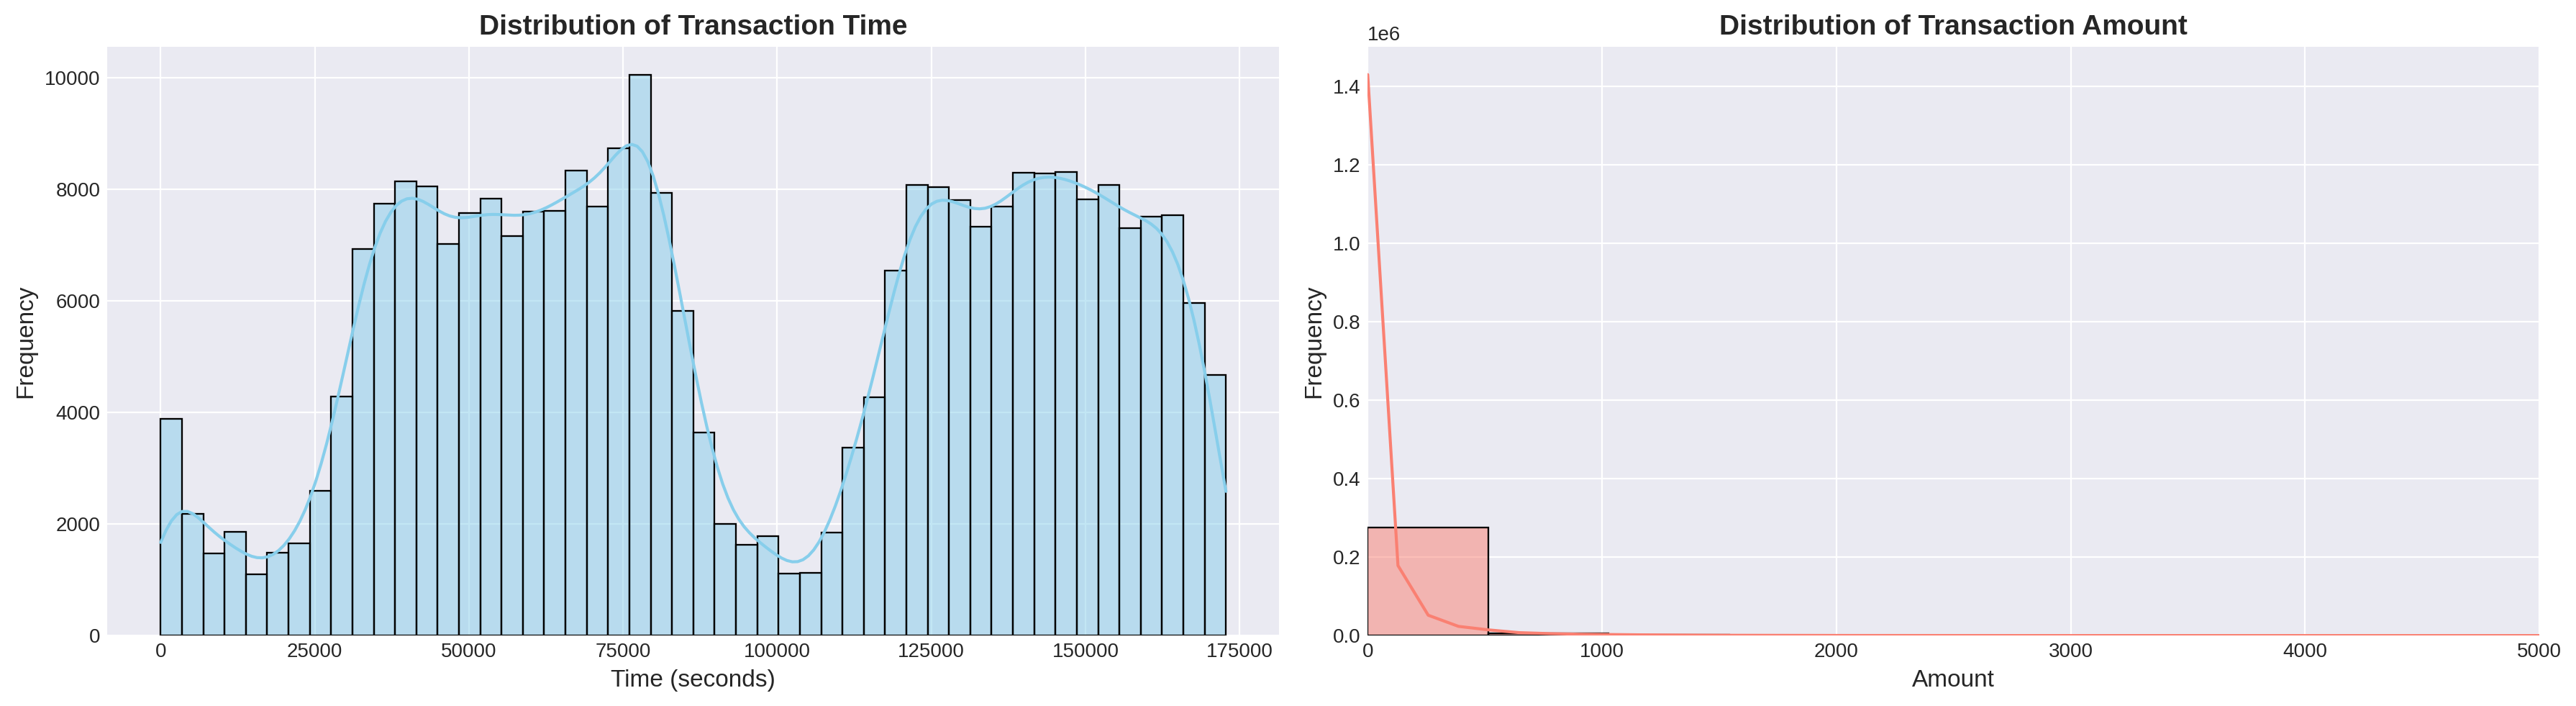

`Time`은 특정 주기를 보이는 듯하며, `Amount`는 대부분의 거래가 소액임을 보여줍니다.
이 두 피처는 다른 V 피처들과 스케일이 다르므로 모델 학습 전 스케일링이 필수적입니다.



In [25]:
# --- Time, Amount 피처 분포 확인 ---
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Time 분포
sns.histplot(df['Time'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Transaction Time', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Time (seconds)', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)

# Amount 분포
sns.histplot(df['Amount'], bins=50, kde=True, ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Transaction Amount', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Amount', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_xlim(0, 5000) # Amount의 범위가 넓으므로 일부만 확대해서 확인

plt.tight_layout()
plt.show()

print("`Time`은 특정 주기를 보이는 듯하며, `Amount`는 대부분의 거래가 소액임을 보여줍니다.")
print("이 두 피처는 다른 V 피처들과 스케일이 다르므로 모델 학습 전 스케일링이 필수적입니다.\n")

In [ ]:
# 2. 데이터 전처리

# RobustScaler 사용: 이상치(outlier)의 영향을 최소화하면서 스케일링
scaler = RobustScaler()
df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

# 기존 Time, Amount 컬럼 삭제
df.drop(['Time', 'Amount'], axis=1, inplace=True)

print("`Amount`와 `Time` 피처를 RobustScaler를 이용해 스케일링 완료했습니다.\n")

`Amount`와 `Time` 피처를 RobustScaler를 이용해 스케일링 완료했습니다.



In [27]:
# --- 데이터셋 분리 ---
X = df.drop('Class', axis=1)
y = df['Class']

# 데이터를 학습용과 테스트용으로 분리. stratify=y 옵션으로 클래스 비율을 유지.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"학습 데이터셋 비율: \n{y_train.value_counts(normalize=True) * 100}")
print(f"\n테스트 데이터셋 비율: \n{y_test.value_counts(normalize=True) * 100}\n")


학습 데이터셋 비율: 
Class
0    99.827251
1     0.172749
Name: proportion, dtype: float64

테스트 데이터셋 비율: 
Class
0    99.827252
1     0.172748
Name: proportion, dtype: float64



In [ ]:
# --- SMOTE 오버샘플링 ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print("SMOTE 적용 전 학습 데이터 분포:\n", y_train.value_counts())
print("SMOTE 적용 후 학습 데이터 분포:\n", y_train_resampled.value_counts())
print("\nSMOTE를 통해 학습 데이터의 소수 클래스(사기 거래)를 오버샘플링하여 클래스 불균형을 해소했습니다.\n")

SMOTE 적용 전 학습 데이터 분포:
 Class
0    213236
1       369
Name: count, dtype: int64
SMOTE 적용 후 학습 데이터 분포:
 Class
0    213236
1    213236
Name: count, dtype: int64

SMOTE를 통해 학습 데이터의 소수 클래스(사기 거래)를 오버샘플링하여 클래스 불균형을 해소했습니다.



In [ ]:
# 3. 머신러닝 모델링
print("\n## 3. 머신러닝 모델링 (Machine Learning Modeling)\n")

# 모델 학습 함수 정의
def train_model(model, X_train, y_train, model_name):
    print(f"--- {model_name} 모델 학습 시작 ---")
    model.fit(X_train, y_train)
    print(f"--- {model_name} 모델 학습 완료 ---\n")
    return model

# 1) 로지스틱 회귀 (Baseline Model)
lr_model = train_model(LogisticRegression(random_state=42, max_iter=1000), X_train_resampled, y_train_resampled, "Logistic Regression")

# 2) LightGBM (Advanced Model)
lgbm_model = train_model(lgb.LGBMClassifier(random_state=42), X_train_resampled, y_train_resampled, "LightGBM")


## 3. 머신러닝 모델링 (Machine Learning Modeling)

--- Logistic Regression 모델 학습 시작 ---
--- Logistic Regression 모델 학습 완료 ---

--- LightGBM 모델 학습 시작 ---
[LightGBM] [Info] Number of positive: 213236, number of negative: 213236
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.139985 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7650
[LightGBM] [Info] Number of data points in the train set: 426472, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
--- LightGBM 모델 학습 완료 ---



In [ ]:
# 4. 결과 분석 및 평가
print("\n## 4. 결과 분석 및 평가 (Results Analysis & Evaluation)\n")

# 모델 평가 함수 정의
def evaluate_model(model, X_test, y_test, model_name):
    print(f"--- {model_name} 모델 평가 ---")
    preds = model.predict(X_test)
    probs = model.predict_proba(X_test)[:, 1] # Positive class(1)에 대한 확률

    # 혼동 행렬 (Confusion Matrix)
    cm = confusion_matrix(y_test, preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Fraud'], yticklabels=['Normal', 'Fraud'])
    plt.title(f'{model_name} - Confusion Matrix', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.show()

    # 분류 리포트 (Classification Report)
    print("\n[Classification Report]")
    report = classification_report(y_test, preds, target_names=['Normal (0)', 'Fraud (1)'])
    print(report)

    # 주요 성능 지표
    accuracy = accuracy_score(y_test, preds)
    roc_auc = roc_auc_score(y_test, probs)
    precision, recall, _ = precision_recall_curve(y_test, probs)
    pr_auc = auc(recall, precision)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"ROC AUC Score: {roc_auc:.4f}")
    print(f"Precision-Recall AUC Score: {pr_auc:.4f}\n")

    return roc_auc, pr_auc, recall, precision


## 4. 결과 분석 및 평가 (Results Analysis & Evaluation)



--- Logistic Regression 모델 평가 ---


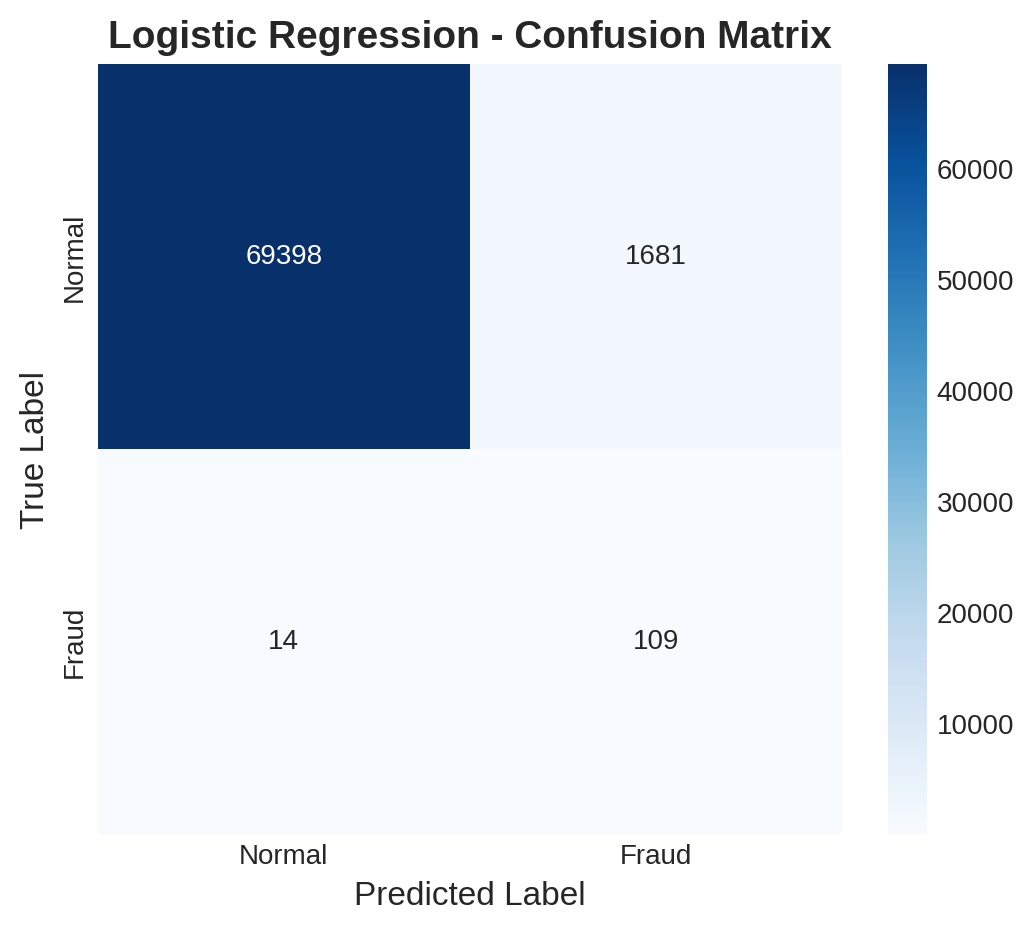


[Classification Report]
              precision    recall  f1-score   support

  Normal (0)       1.00      0.98      0.99     71079
   Fraud (1)       0.06      0.89      0.11       123

    accuracy                           0.98     71202
   macro avg       0.53      0.93      0.55     71202
weighted avg       1.00      0.98      0.99     71202

Accuracy: 0.9762
ROC AUC Score: 0.9719
Precision-Recall AUC Score: 0.7507

--- LightGBM 모델 평가 ---


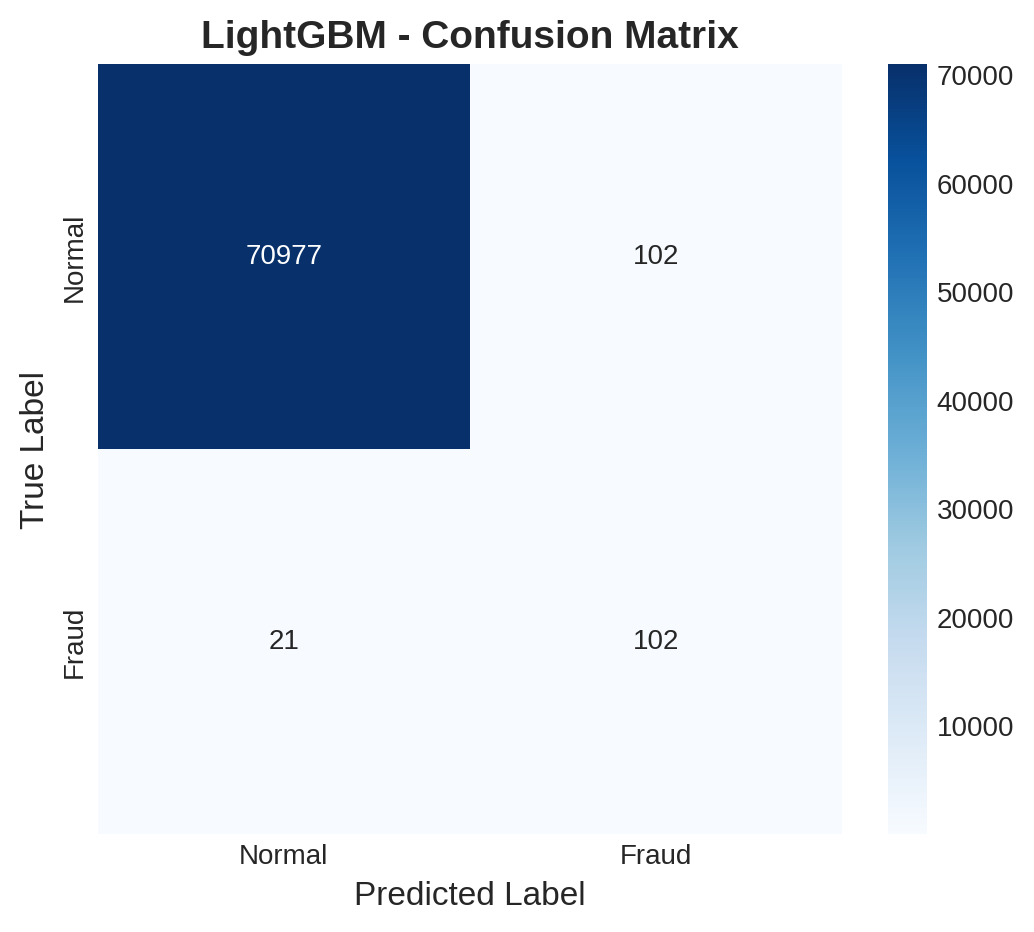


[Classification Report]
              precision    recall  f1-score   support

  Normal (0)       1.00      1.00      1.00     71079
   Fraud (1)       0.50      0.83      0.62       123

    accuracy                           1.00     71202
   macro avg       0.75      0.91      0.81     71202
weighted avg       1.00      1.00      1.00     71202

Accuracy: 0.9983
ROC AUC Score: 0.9605
Precision-Recall AUC Score: 0.7286



In [31]:
# 각 모델 평가
lr_roc_auc, lr_pr_auc, lr_recall, lr_precision = evaluate_model(lr_model, X_test, y_test, "Logistic Regression")
lgbm_roc_auc, lgbm_pr_auc, lgbm_recall, lgbm_precision = evaluate_model(lgbm_model, X_test, y_test, "LightGBM")

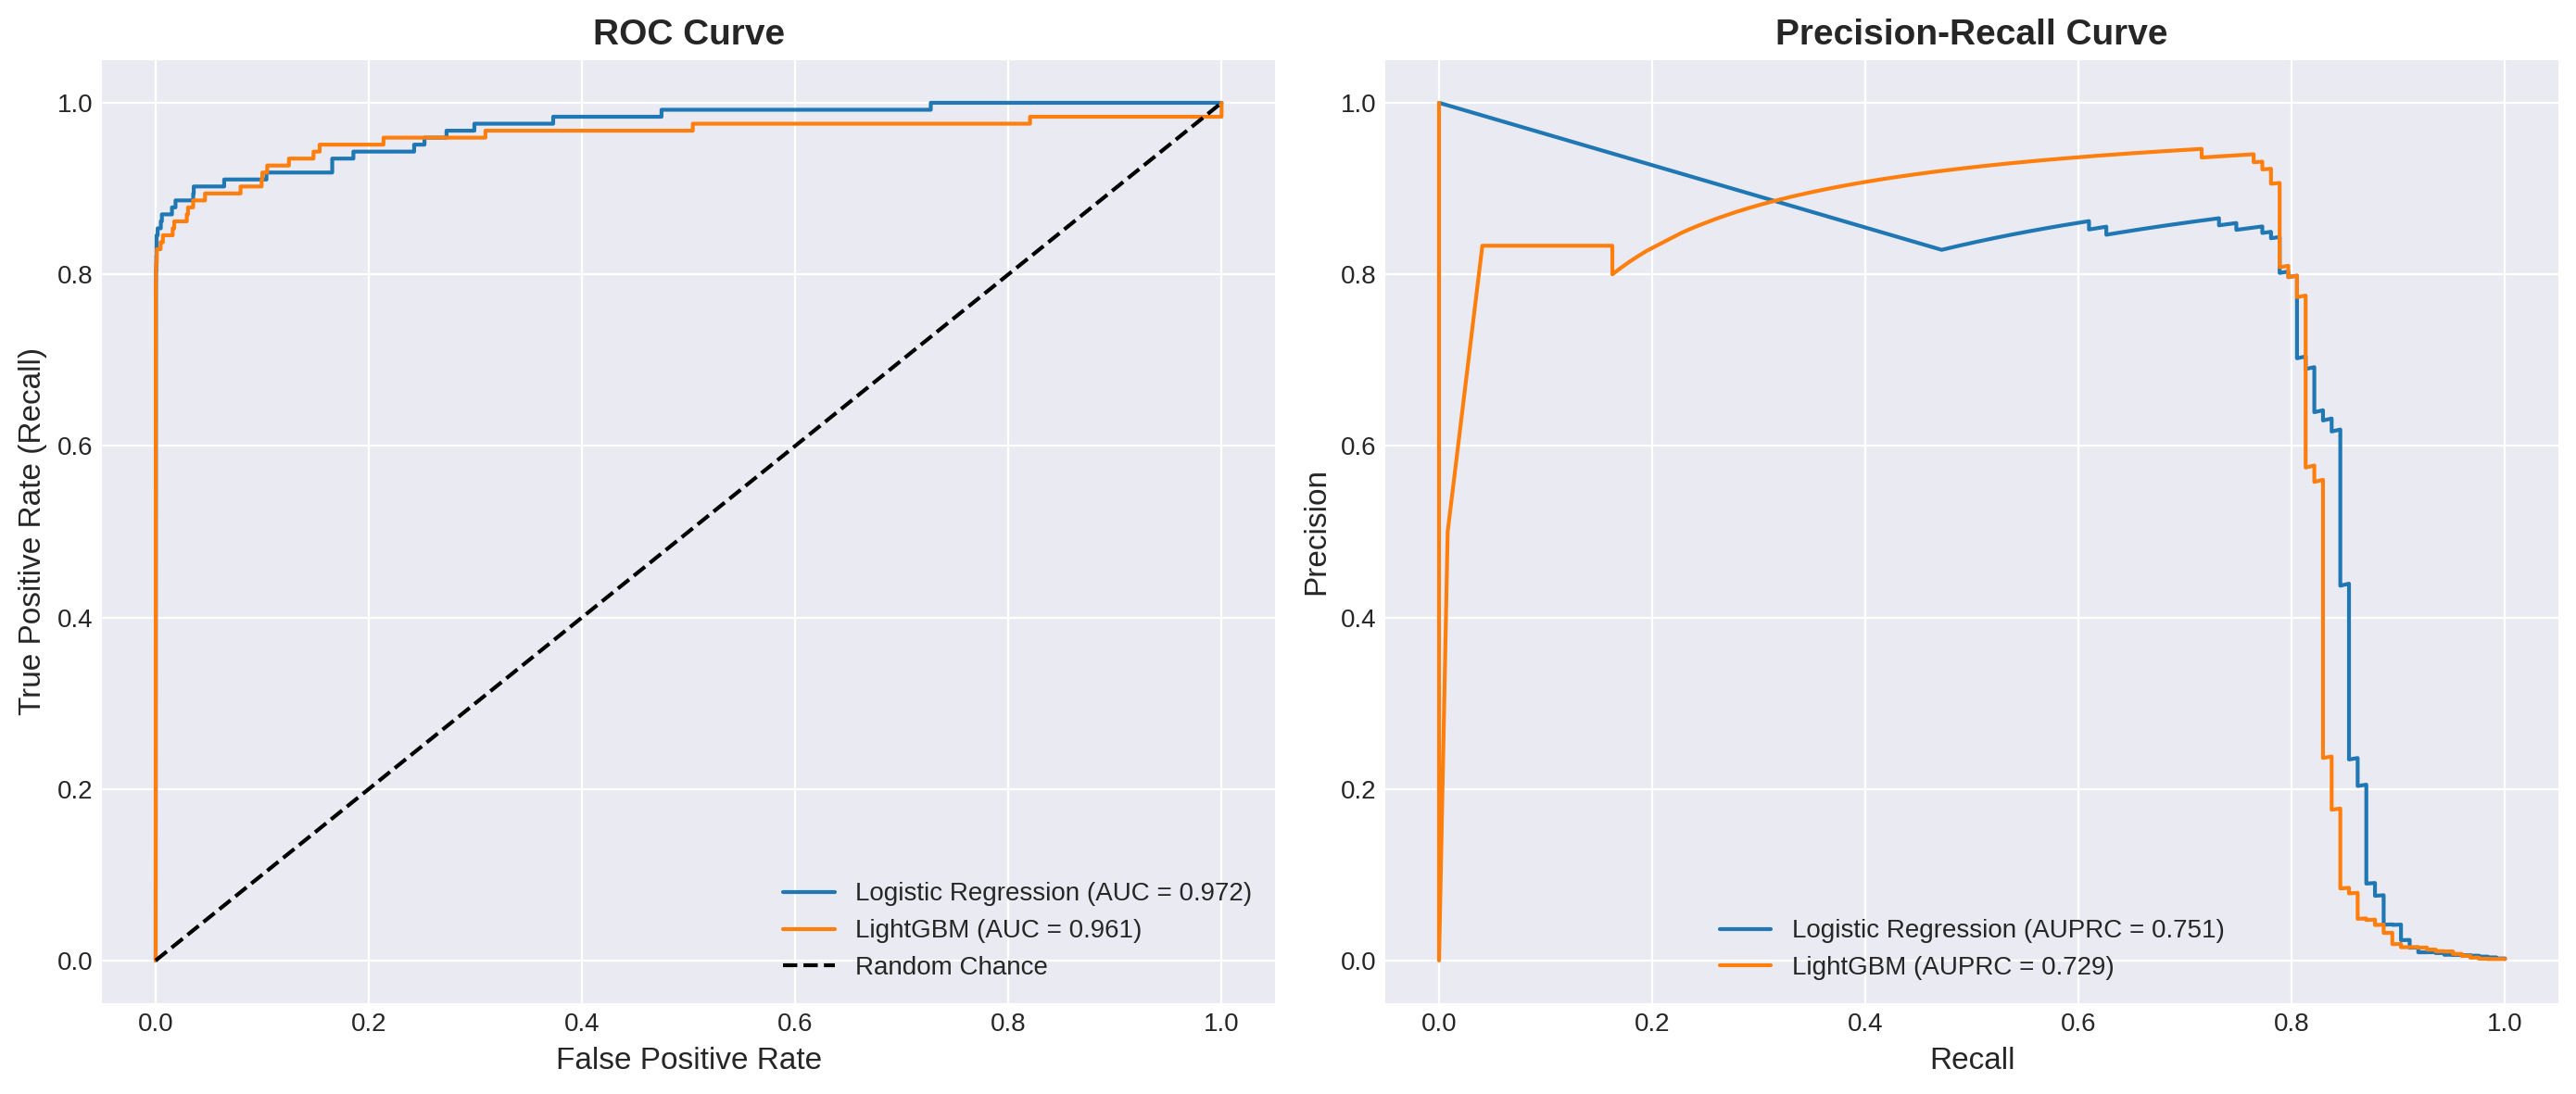

In [34]:
# --- 모델 성능 비교 시각화 ---
plt.figure(figsize=(14, 6))

# 1) ROC Curve
plt.subplot(1, 2, 1)
# 모델별 ROC Curve는 별도로 계산해야 합니다. (위 함수에서는 AUC 값만 계산)
from sklearn.metrics import roc_curve
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_model.predict_proba(X_test)[:,1])
lgbm_fpr, lgbm_tpr, _ = roc_curve(y_test, lgbm_model.predict_proba(X_test)[:,1])

plt.plot(lr_fpr, lr_tpr, label=f'Logistic Regression (AUC = {lr_roc_auc:.3f})')
plt.plot(lgbm_fpr, lgbm_tpr, label=f'LightGBM (AUC = {lgbm_roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random Chance')
plt.title('ROC Curve', fontsize=14, fontweight='bold')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate (Recall)', fontsize=12)
plt.legend()
plt.grid(True)

# 2) Precision-Recall Curve
plt.subplot(1, 2, 2)
plt.plot(lr_recall, lr_precision, label=f'Logistic Regression (AUPRC = {lr_pr_auc:.3f})')
plt.plot(lgbm_recall, lgbm_precision, label=f'LightGBM (AUPRC = {lgbm_pr_auc:.3f})')
plt.title('Precision-Recall Curve', fontsize=14, fontweight='bold')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()